# Grad-CAM in PyTorch

This is a Grad-CAM implementation in Pytorch inspired by @kazuto1011's work (https://github.com/kazuto1011/grad-cam-pytorch).

I modified his code in order to deal with following needs
- to process multiple images based on their own class labels
- initialize gradcam with target layer to avoid out-of-memory error
- add bounding boxes using skimage

In [1]:
import numpy as np
import glob

import torch
import torch.nn as nn
from torch.nn import functional as F

from torchvision import models as vmodels
from torchvision import transforms as transforms

from skimage.transform import resize
from skimage.measure import regionprops, label
from PIL import Image as pil_image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from gradcam import GradCAM

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
img_paths = glob.glob("samples/*.jpg")

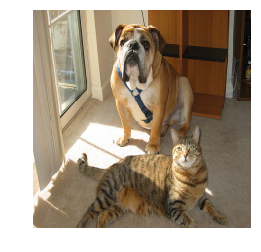

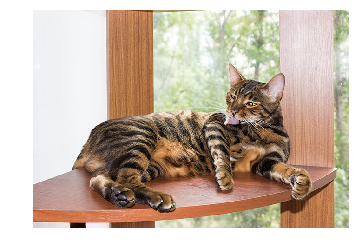

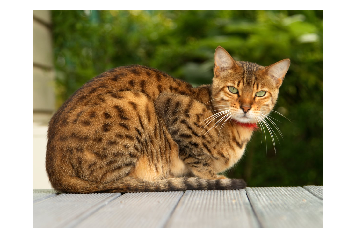

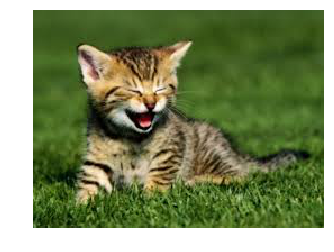

In [3]:
for img in img_paths:
    plt.imshow(plt.imread(img))
    plt.axis("off")
    plt.show()

# Load images

In [4]:
transform_pipeline = transforms.Compose([
    transforms.Resize((197, 197)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
input_tensor = torch.stack([
    transform_pipeline(pil_image.open(path)) for path in img_paths
])

input_tensor = input_tensor.to(device)

# Load model and gradcam

In [6]:
model = vmodels.resnet152(pretrained=True)
model = model.to(device)

In [7]:
gradcam = GradCAM(model, 'layer4.2')

# Generate gradcams & bounding boxes

In [8]:
preds = gradcam.forward(input_tensor)

In [9]:
# manually input class labels or the predicted labels
pred_idx = [243, 285, 285, 285]
# pred_idx = preds.argmax(dim=1).cpu().numpy()
print(pred_idx)

[243, 285, 285, 285]


In [10]:
gradcam.backward(pred_idx)

In [11]:
gradcams = gradcam.generate()

In [12]:
def extract_bboxes(canvas, threshold):
    labeled = label(canvas > threshold)
    bboxes = regionprops(labeled)
    rects = []
    for b in bboxes:
        ys, xs, ye, xe = b.bbox
        w = xe - xs
        h = ye - ys

        rect = Rectangle((xs, ys), w, h, 
                         linewidth=3, color='r', 
                         fill=None, alpha=0.5)
        rects.append(rect)
    return rects

# Visualize results

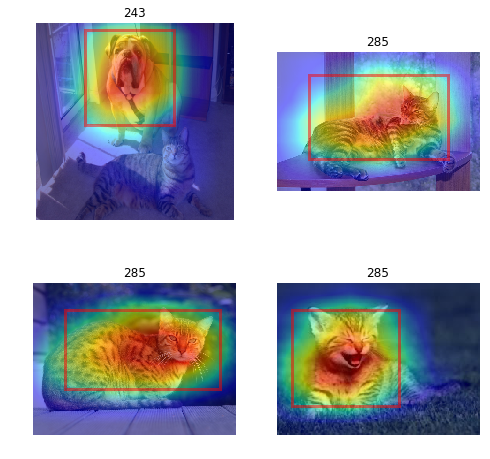

In [13]:
ncol = 2
nrow = np.ceil(len(img_paths) / ncol).astype(int)
base_frame_size = 4
figsize = (base_frame_size * nrow, base_frame_size * ncol)
fig, ax = plt.subplots(nrow, ncol, figsize=figsize)

for idx in range(len(img_paths)):
    h, w, c = plt.imread(img_paths[idx]).shape
    resized_canvas = resize(gradcams[idx], (h, w))
    rects = extract_bboxes(resized_canvas, 0.5)
    
    crow = idx // ncol
    ccol = idx % ncol
    
    ax[crow, ccol].imshow(plt.imread(img_paths[idx]))
    ax[crow, ccol].imshow(resized_canvas, cmap='jet', alpha=0.5)
    for rect in rects:
        ax[crow, ccol].add_patch(rect)
    ax[crow, ccol].axis("off")
    ax[crow, ccol].set_title(pred_idx[idx])

plt.show()

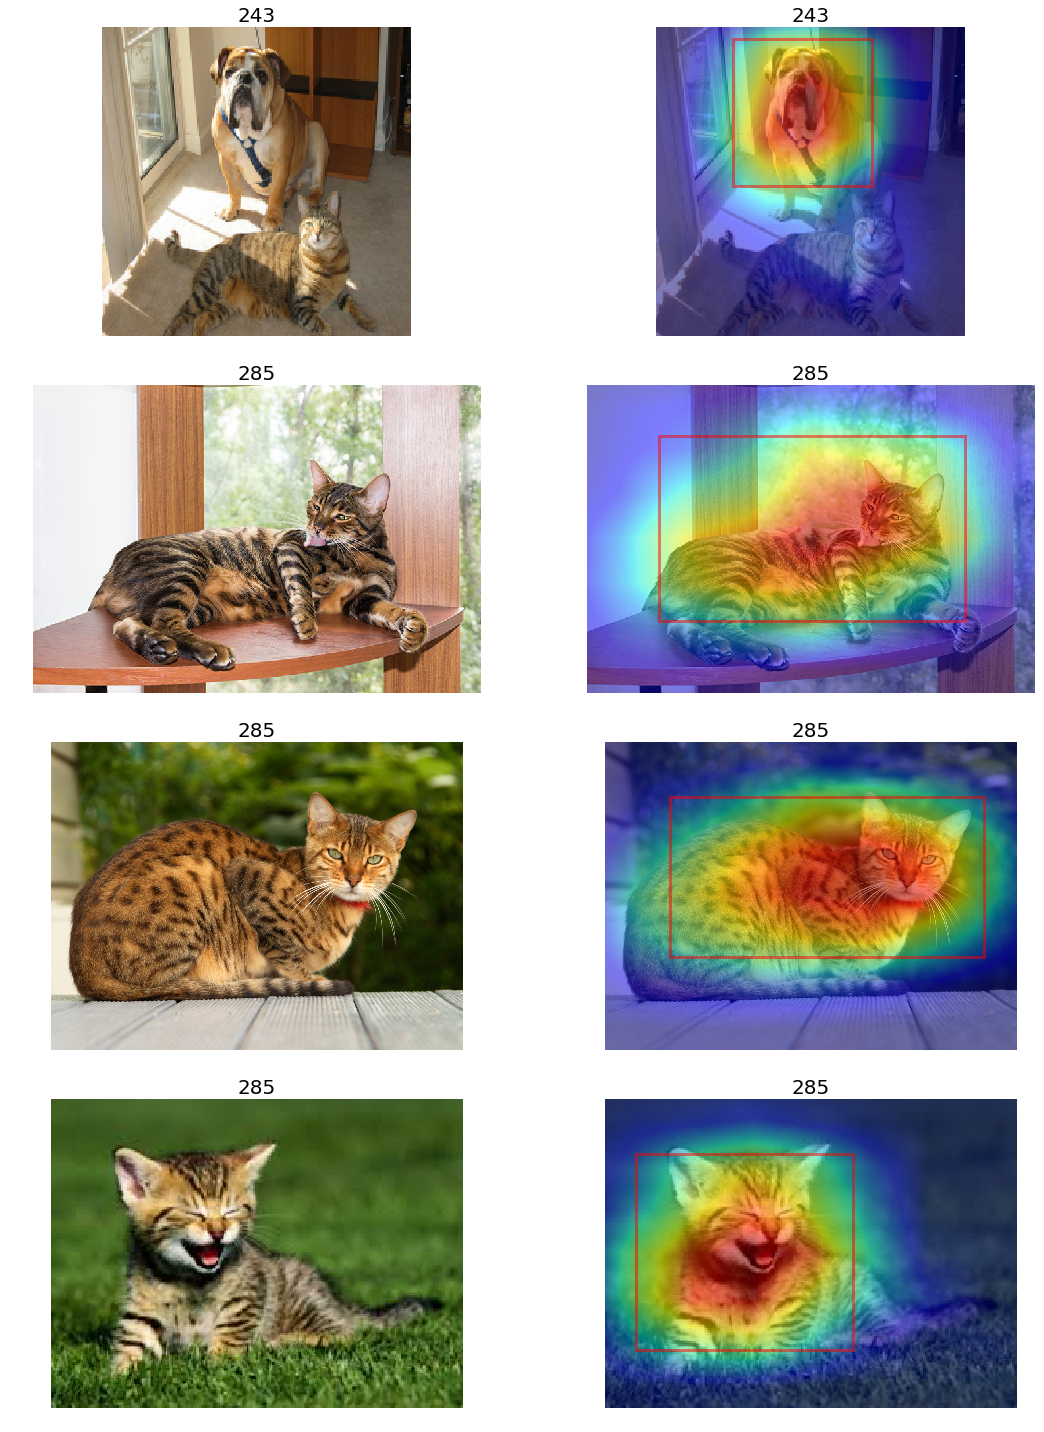

In [14]:
nb_images = len(img_paths)
fig, ax = plt.subplots(nb_images, 2, figsize=(nb_images * 4, 2 * 10))

for idx in range(nb_images):
    ax[idx, 0].imshow(plt.imread(img_paths[idx]))
    ax[idx, 0].axis("off")
    
    h, w, c = plt.imread(img_paths[idx]).shape
    resized_canvas = resize(gradcams[idx], (h, w))
    rects = extract_bboxes(resized_canvas, 0.5)
    
    ax[idx, 1].imshow(plt.imread(img_paths[idx]))
    ax[idx, 1].imshow(resized_canvas, cmap='jet', alpha=0.5)
    for rect in rects:
        ax[idx, 1].add_patch(rect)
    ax[idx, 1].axis("off")
    
    ax[idx, 0].set_title(pred_idx[idx], fontsize=20)
    ax[idx, 1].set_title(pred_idx[idx], fontsize=20)

plt.tight_layout()
plt.show()